# Computer Vision - Assignment 1 - Convolution and Derivatives

#### 10 (+3) points   |   Due date: October 28, 23:59   |   Submission site: https://pradogrado2223.ugr.es/

### Student's Full Name: Pedro Ramos Suárez

The goal of this assignment is to learn how to use OpenCV to implement convolution-based image filtering techniques. 


---


## Normas de entrega

Para este trabajo, al igual que para los demás, se deben presentar  las valoraciones y decisiones adoptadas en cada uno de los apartados. También deberá incluirse una valoración sobre la calidad de los resultados obtenidos. Se recuerda que código sin informe explicativo no puntúa.

Este trabajo de implementación tiene como objetivo principal aprender a implementar filtros de convolución y, particularmente, el cálculo de las derivadas de una imagen. El documento pdf sobre Gaussian discretization disponible en PRADO (https://pradogrado2223.ugr.es/pluginfile.php/209014/mod_folder/content/0/Bibliografia/Gaussian_discretization.pdf) puede resultar de gran utilidad para la implementación del ejercicio 1.A.

Normas de entrega (EL INCUMPLIMIENTO DE ESTAS NORMAS SIGNIFICA PÉRDIDA DIRECTA DE 1 PUNTO CADA VEZ QUE SE DETECTE UN INCUMPLIMIENTO):

1. El diseño de celdas del documento debe ser respetado.
2. Solo se entregará el código fuente (fichero .ipynb) y no se enviarán las imágenes empleadas.
3. Los path que se usen en la lectura de imágenes o cualquier otro fichero de entrada debe ser siempre “/content/drive/My Drive/images/nombre_fichero”
4. El código deberá  presentarse con los resultados obtenidos en cada apartado junto con los  correspondientes comentarios y valoraciones.  Recuerde que la entrega de código sin informe explicativo o valoraciones no puntúa.

---

In [ ]:
# We start by getting access to the drive
from google.colab import drive
drive.mount('/content/drive')
# change directory
%cd '/content/drive/MyDrive'
# the current directory
%pwd
import os
# this definition allows to read files in a specific path
get_image = lambda route: os.path.join('/content/drive/MyDrive/images', route)

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
import sys,os
# Let's import the python module P0. 
# You must create the directory CV and put inside the file P0.py
# P0.py is the module created from your notebook P0.
path_to_module='/content/drive/MyDrive/CV/'
sys.path.append(os.path.abspath(path_to_module))

import P0

In [ ]:
# We import the modules to use
import math
import cv2
import numpy as np
from matplotlib import pyplot as plt
# This allows to display images and to save them in cells
%matplotlib inline

# **Exercise-1**: Write Python code to implement the following tasks efficiently (4 points). 




## A)

Compute discrete masks of the 1D Gaussian and its normalized first and second derivatives. Consider both the size of the mask and the sigma value as possible inputs. Use the sigma values {1, 2.3, 3.7,5} and size masks {7,11,15} as inputs, and draw the mask values as 1D graphs using matplotlib. (1.5 points)

Primero, veamos la función gaussiana y sus derivadas que usaremos para construir el vector:

In [ ]:
import sympy as sp
from IPython.display import display

x, s = sp.symbols(u'x,σ')
gaussian = sp.exp(-(x**2 / (2*s**2)))

display("Gaussian: ", gaussian)
display("Gaussian first derivative: ", sp.diff(gaussian, x, 1))
display("Gaussian second derivative: ", sp.diff(gaussian, x, 2))

'Gaussian: '

exp(-x**2/(2*σ**2))

'Gaussian first derivative: '

-x*exp(-x**2/(2*σ**2))/σ**2

'Gaussian second derivative: '

(x**2/σ**2 - 1)*exp(-x**2/(2*σ**2))/σ**2

Esta función viene de la distribución normal, cuya función de densidad es:
$$f(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^{2}}$$
Como consideramos una distribución centrada en 0, es decir, con $\mu=0$, tenemos:
$$f(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{x^{2}}{2\sigma^{2}}}$$
Podemos ver que esta función se diferencia de nuestra gaussiana en el término que múltiplica a la exponencial. Esto se debe a que, una vez fijado $\sigma$, es una constante, y como queremos que la suma de todos los términos sume 1, al normalizar vamos a dividir cada término entre la suma de todos ellos, por lo que multiplicar por una constante sólo provocará que dividamos por ella al normalizar, así que podemos omitarla y hacer así los cálculos mas sencillos y rápidos.

Tenemos dos opciones: implementar la gaussiana y sus derivadas como funciones para poder evaluarlas en distintos puntos o, para poder automatizar derivadas de distintos órdenes, usar sympy para calcular la derivada, como hacemos a continuación:

In [ ]:
def gaussian(x_, sigma=1, order=0):
  x = sp.Symbol('x')
  gaussian = sp.exp(-(x**2 / (2*sigma**2)))
  
  return sp.diff(gaussian, x, order).subs(x, x_).evalf()

Aunque utilizar sympy puede ser algo mas complejo, tiene sus ventajas, ya que nos permite poder utilizar cualquier orden de derivada utilizando una única función, y asi cuando tengamos que llamarla podemos usar directamente esta única función en lugar de tener que hacer un caso para cada orden de derivada.

Recordemos que para normalizar por escala la máscara tenemos que multiplicar el valor obtenido de la gaussiana por σ elevado al orden de la derivada, es decir, si la gaussiana es:

$$g(x) = e^{-\frac{-x^{2}}{2\sigma^{2}}}$$

La máscara de la primera derivada se obtendrá de:

$$\frac{\delta g(x)}{\delta x} \cdot \sigma = -\frac{x}{\sigma^{2}} \cdot g(x) \cdot \sigma = -\frac{x}{\sigma} g(x)$$

Y la máscara de la segunda derivada de:

$$\frac{\delta^{2} g(x)}{\delta x^{2}} \cdot \sigma^{2} = \frac{(\frac{x^{2}}{\sigma^{2}} - 1) \cdot g(x)}{\sigma^{2}} \cdot \sigma^{2} = (\frac{x^{2}}{\sigma^{2}} - 1) g(x)$$

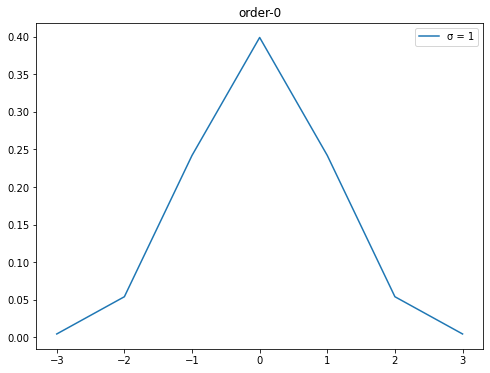

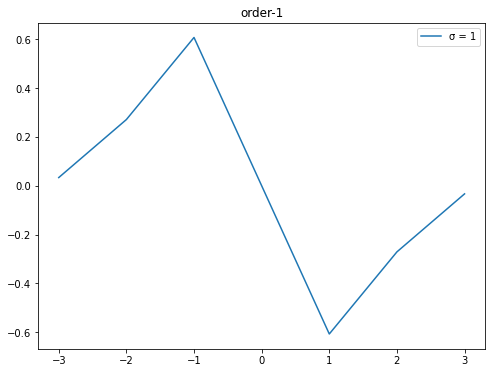

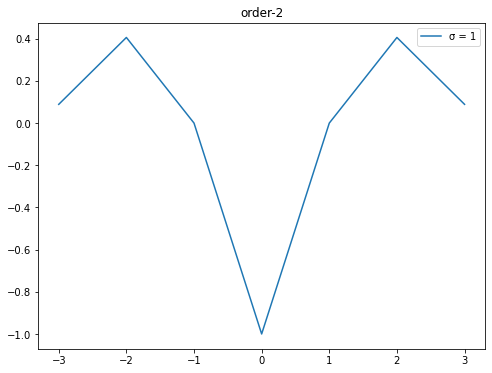

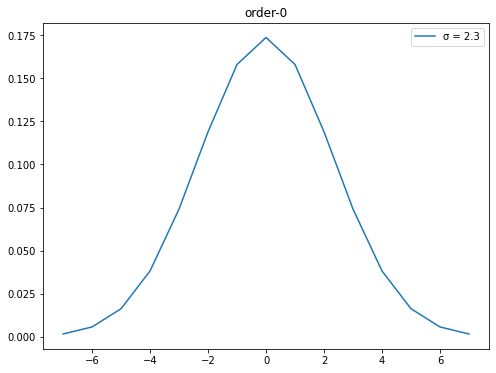

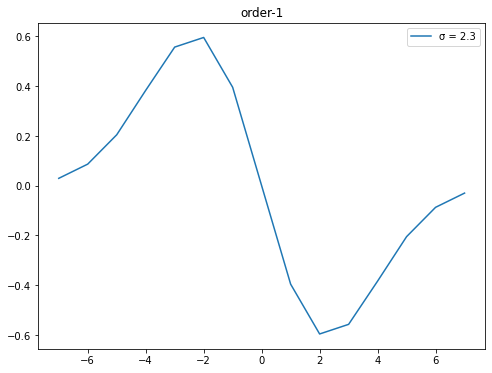

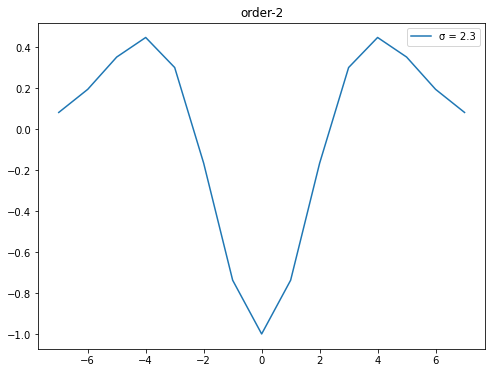

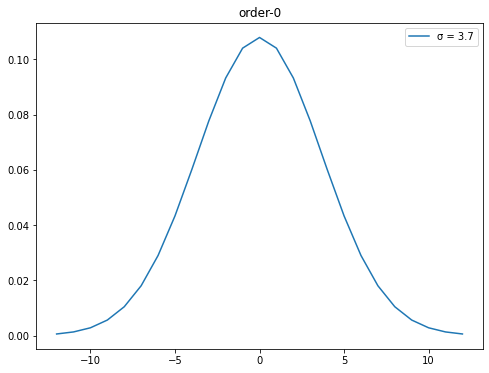

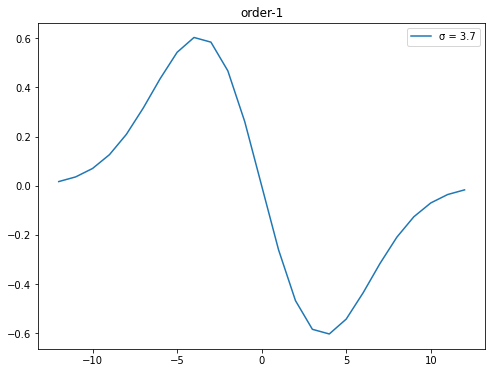

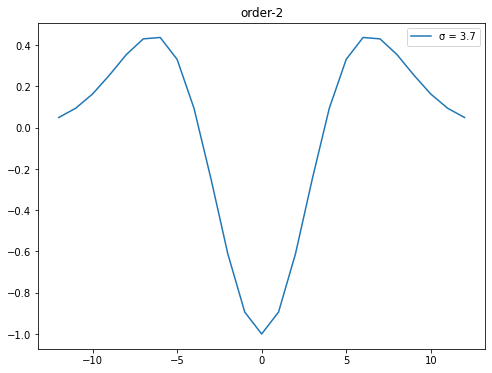

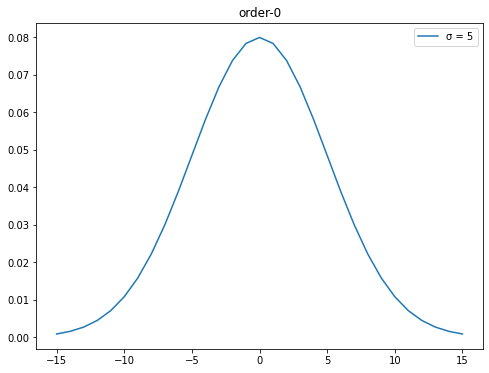

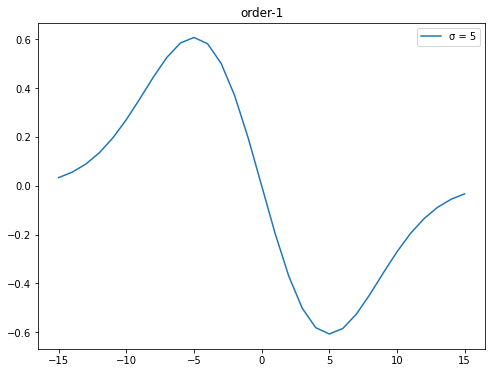

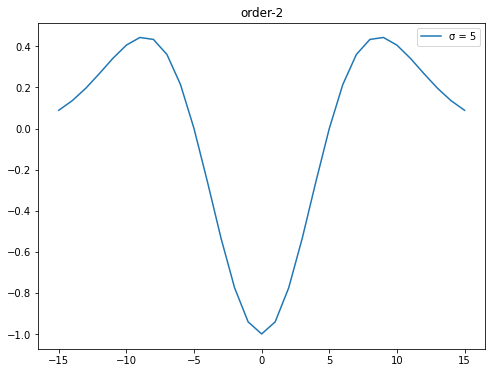

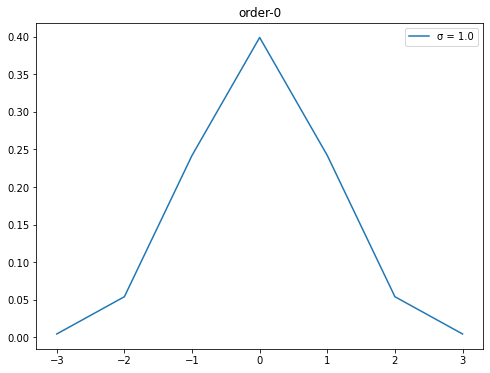

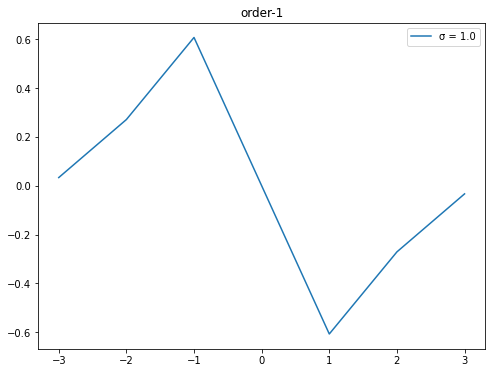

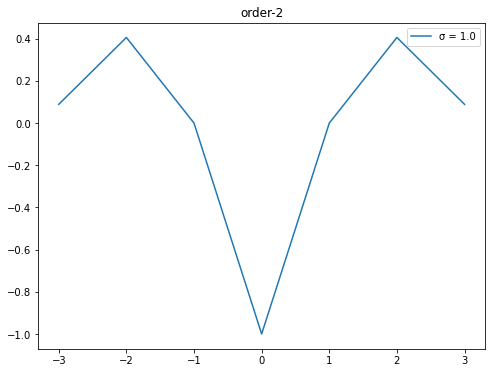

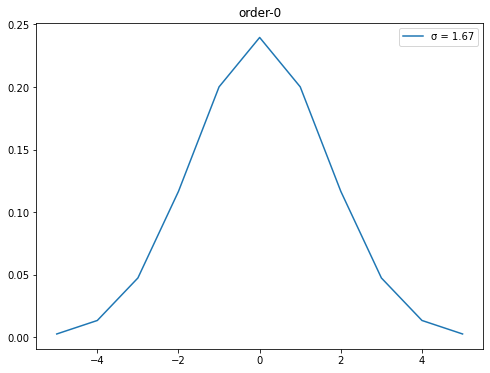

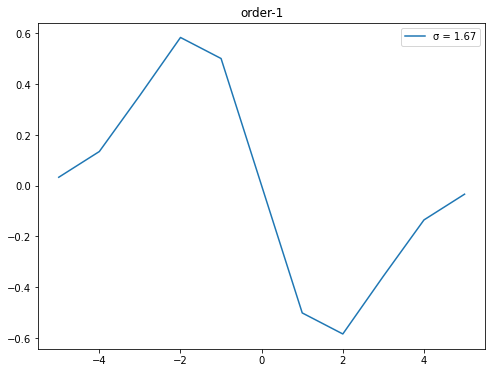

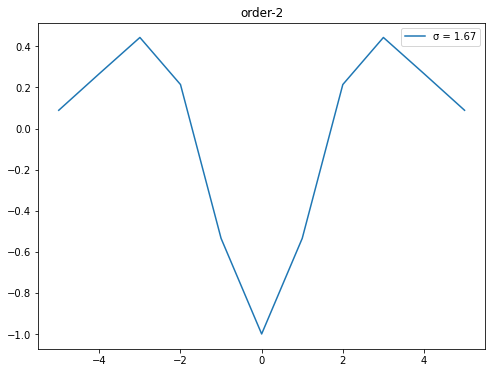

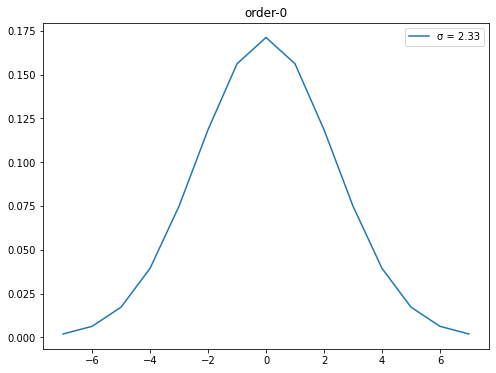

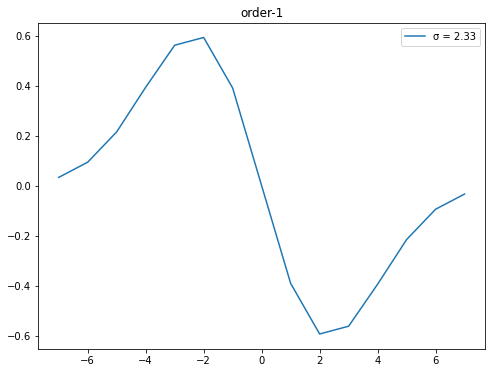

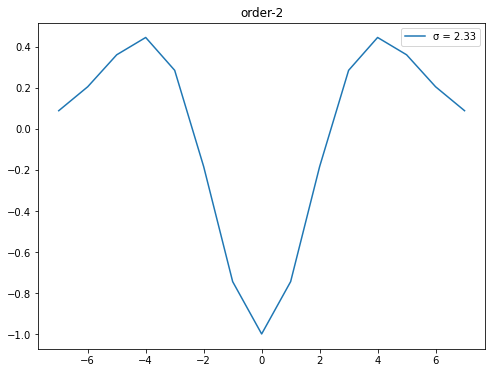

In [ ]:
def gaussianMask1D(sigma=0, sizeMask=0, order=0):
  # If sizeMask is 0, calculate it from sigma
  if sizeMask == 0:
    sizeMask = 2 * math.ceil(3 * sigma) + 1

  # If sigma is 0, calculate it from sizeMask
  elif sigma == 0:
    sigma = (sizeMask - 1) / 6

  # If sigma and sizeMask are 0, return error
  elif sigma == 0 and sizeMask == 0:
    print("Error: Either sigma or the size of the mask must be bigger than 0.")

  # Calculate k, the number of elements on each size
  k = int((sizeMask - 1) / 2)
  mask = np.empty(0)

  # Calculate the value of each point
  # Value obtained from the gaussian function multiplied by sigma to the power of the order
  for i in range(-k, k+1):
    mask = np.append(mask, gaussian(i, sigma, order) * sigma**order)

  # The sum of the mask must be 1
  if order == 0:
    mask = mask / np.sum(mask)

  return mask

def plotGraph(graph, title='No title'):
  plt.rcParams["figure.figsize"] = (8,6)
  x = np.arange(-(len(graph) - 1)/2, (len(graph) - 1)/2 + 1, 1.0)
  plt.plot(x, graph, label='σ = '+str(round(sigma, 2)))
  plt.title(title)
  plt.legend()
  plt.show()

# Let's check the functions
# You must experiment with different values for sigma and sizeMask
# Write down your conclusions 
sigmas = [1, 2.3, 3.7, 5]
sizesMask = [7, 11, 15]
orders = [0, 1, 2]

for sigma in sigmas:
  for order in orders:
    plotGraph(gaussianMask1D(sigma, 0, order),title='order-'+str(order))

for sizeMask in sizesMask:
  # Calculate sigma for the label
  sigma = (sizeMask - 1) / 6
  for order in orders:
    plotGraph(gaussianMask1D(0, sizeMask, order),title='order-'+str(order))

Para una visualización más cómoda de la discretización, podemos verlo como un diagrama de barras frente a la ''curva'' que se puede ver al tomar un número muy alto de puntos.

Nótese que multiplicamos los valores obtenidos de la gaussiana para compensar las modificaciones realizadas al normalizar la escala, pero debido a que multiplicamos todos los valores por la misma constante, no modifica la forma.

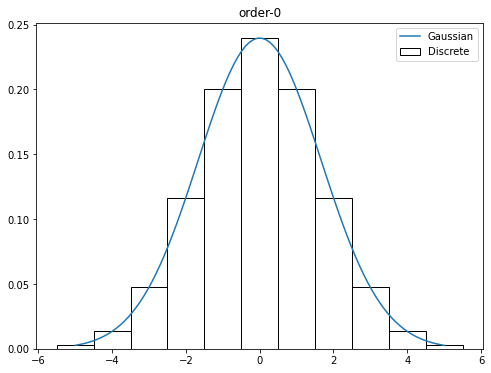

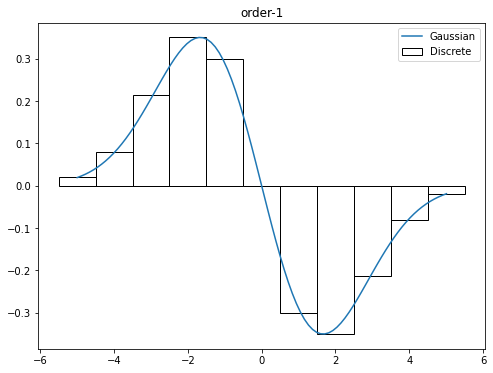

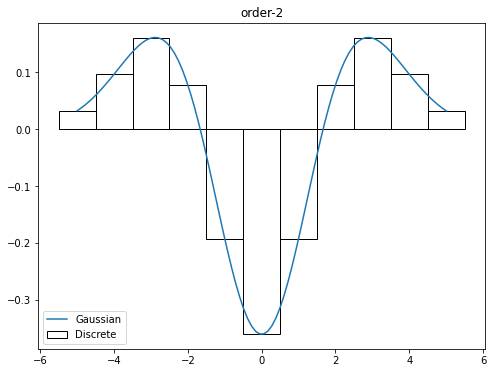

In [ ]:
def plotGaussian(sigma=0, sizeMask=0, order=0, title=''):
  # If sizeMask is 0, calculate it from sigma
  if sizeMask == 0:
    sizeMask = 2 * math.ceil(3 * sigma) + 1

  # If sigma is 0, calculate it from sizeMask
  elif sigma == 0:
    sigma = (sizeMask - 1) / 6

  # If sigma and sizeMask are 0, return error
  elif sigma == 0 and sizeMask == 0:
    print("Error: Either sigma or the size of the mask must be bigger than 0.")

  # Calculate k, the number of elements on each size
  k = int((sizeMask - 1) / 2)
  discrete = np.empty(0)

  # Calculate the value of each point
  # Value obtained from the gaussian function multiplied by sigma to the power of the order
  x_discrete = np.arange(-k, k+1, 1)
  for i in range(-k, k+1):
    discrete = np.append(discrete, gaussian(i, sigma, order))# * sigma**order)

  # The sum of the mask must be 1
  if order == 0:
    discrete = discrete / np.sum(discrete)

  # Calculate the gaussian function
  step = sizeMask / 100
  x_gauss = np.arange(-k, k+step, step)
  gauss = np.empty(0)
  for x in x_gauss:
    gauss = np.append(gauss, gaussian(x, sigma, order))

  # Scale the gaussian function to the discrete to compensate normalization
  gauss *= abs(max(discrete, key=abs) / max(gauss, key=abs))

  plt.bar(x_discrete, discrete, width=1.0, fill=False, label="Discrete")
  plt.plot(x_gauss, gauss, label="Gaussian")

  plt.rcParams["figure.figsize"] = (8,6)
  plt.legend()
  plt.title(title)

  plt.show()

sigma=0
sizeMask=11
plotGaussian(sigma, sizeMask, order=0, title='order-0')
plotGaussian(sigma, sizeMask, order=1, title='order-1')
plotGaussian(sigma, sizeMask, order=2, title='order-2')

Por último, podemos preguntarnos cuál es la importancia de normalizar la escala. Para ello, veamos el siguiente ejemplo:

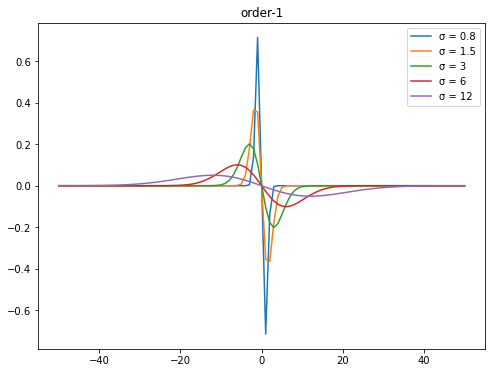

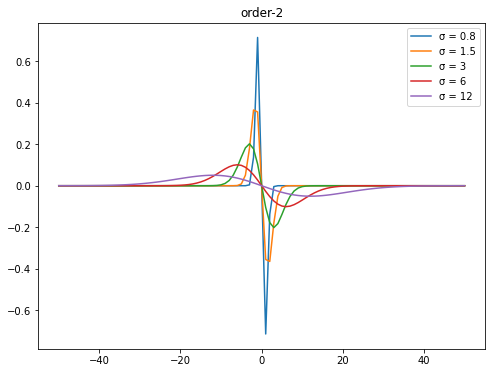

In [ ]:
def plotGauss(sigma, order, k=50, title=''):
  x = np.arange(-k, k+1, 1)
  y = []
  for i in x:
    y.append(gaussian(i, sigma, order))
  plt.rcParams["figure.figsize"] = (8,6)
  plt.plot(x, y, label='σ = '+str(sigma))
  plt.title(title)
  plt.legend()

sigmas = [0.8,1.5,3,6,12]
orders = [1, 2]
for order in orders:
  for sigma in sigmas:
    plotGauss(sigma, order=1, title='order-'+str(order))
  plt.show()

Podemos ver como los máximos y mínimos de la función van disminuyendo al aumentar sigma. Esto se debe a que, si no multiplicamos por sigma, el área entre las curvas y el eje X se conserva para todos los valores de sigma, y como al aumentar el valor de sigma disminuimos la pendiente cerca del máximo, lo provocaría un aumento del área, que se compensa disminuyendo la altura.

Veamos en el siguiente ejemplo como la normalización por escala sirve para solucionar este problema.

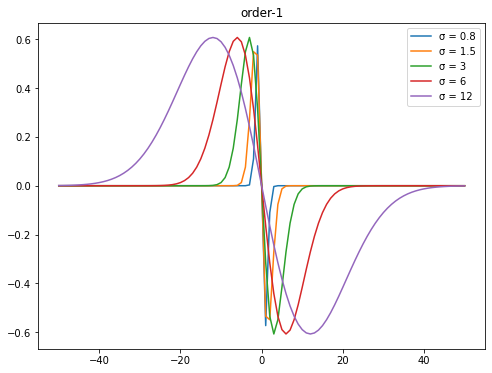

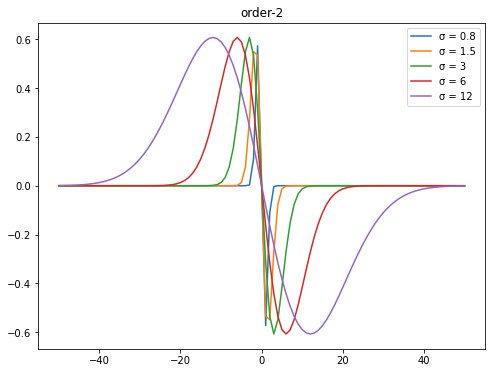

In [ ]:
def plotGaussSigma(sigma, order, k=50, title=''):
  x = np.arange(-k, k+1, 1)
  y = gaussianMask1D(sigma=sigma, sizeMask=2*k+1, order=order)
  plt.rcParams["figure.figsize"] = (8,6)
  plt.plot(x, y, label='σ = '+str(sigma))
  plt.title(title)
  plt.legend()

sigmas = [0.8,1.5,3,6,12]
orders = [1, 2]
for order in orders:
  for sigma in sigmas:
    plotGaussSigma(sigma, order=1, title='order-'+str(order))
  plt.show()

## B)




Read an image in gray level. Smooth it applying the convolution with masks defined by a set of increasing sigma values, i.e. sigma= 0.8,1.5,3,6,12. Display all smoothed images in the same canvas. Use the OpenCV’s function `sepFilter2D()` with masks computed using your functions from (A). (1.5 points)

Primero, como para este ejercicio vamos a visualizar diversas imágenes cuyos píxeles toman valores en intervalos distintos, la función que utilizábamos en la P0 para representar varias imágenes simultáneamente combinando las imágenes en una única imagen de salida que normalizaba antes de imprimir por pantalla no nos sirve, ya que normalizaría todas las imágenes por los valores de la imágen más alta.

Debido a ello, realizamos una modificación a dicha función para que normalice cada imagen por separado antes de combinarlas.

In [ ]:
def displayMI_ES(vim, title='', factor=1):
  rows, columns = P0.imDistribution(len(vim))
  vim = vim.copy()

  # MODIFIED FROM P0: Normalize images
  for i in range(len(vim)):
    vim[i] = P0.rangeDisplay01(vim[i], 1)

  # First row
  out = vim[0].copy()
  for i in range(1, columns):
    out = np.hstack((out, vim[i]))

  # Adding more rows
  for i in range(1, rows):
    temp = vim[i * columns].copy()
    for j in range(1, columns):
      if i * columns + j < len(vim):
        temp = np.hstack((temp, vim[i * columns + j]))
      else:
        temp = np.hstack((temp, np.zeros(vim[i*columns].shape, dtype=vim[i*columns].dtype)))
    out = np.vstack((out, temp))

  return P0.displayIm(out, title, factor)

Para este ejercicio queremos aplicar una máscara a una imagen. La máscara que vamos a aplicar es una matriz resultante del producto de un vector fila por un vector por columna, y por la linealidad de las máscaras obtenemos los mismos resultados tanto aplicando la matriz resultante del producto como cada array por separado, siendo ésta segunda forma más eficiente en tiempo de ejecución.

Para ello, utilizamos cv2.sepFilter2D(), que es una función que realiza precisamente este proceso, tomando como parámetros la imagen a la que queremos aplicar la máscara y los vectores máscara, separando cada eje en arrays distintos.

Las máscaras que utilizaremos serán la gaussiana y sus derivadas, cuyo orden representaremos en un array de tamaño dos, donde el primer elemento representa el orden de la derivada de la máscara del eje X, y el segundo elemento el orden de la derivada de la máscara del eje Y, considerando orden 0 como la máscara sin derivar. Estas máscaras las obtenemos del ejercicio anterior.

Al aplicar una máscara derivada tenemos que tener en cuenta que, si la función gausianna es $G(x, y)$, tenemos:
$$\frac{\delta G(x, y)}{\delta x} = G'(x) \cdot G(y)$$
$$\frac{\delta G(x, y)}{\delta y} = G(x) \cdot G'(y)$$
Es decir, aplicamos la máscara derivada en el eje que estamos derivando y la gaussiana en el otro eje.

Debido a ello, tenemos que distinguir tres casos:


*   Máscara de órdenes [0, 0]: En este caso, utilizamos la máscara gaussiana sin derivar en ambos ejes.
*   Máscara de órdenes [x, 0] ó [0, y]: En este caso, utilizamos la máscara gaussiana en el eje correspondiente al orden 0 y la derivada de orden x o y en el otro eje X o Y respectivamente.
*   Máscara de órdenes [x, y]: En este caso, la imagen resultande es la obtenida de la suma de las imágenes obtenidas de aplicar las máscaras de órdenes [x, 0] y [0, y].

Hay que tener en cuenta que estas máscaras nos pueden cambiar el rango de los valores de las imágenes, por lo que siempre tenemos que normalizar después de aplicar la máscara. Teniendo todo eso en cuenta, el código queda de la siguiente forma:

In [ ]:
def my2DConv(im, sigma, orders):
  copy = im.copy()
  gaussianMask = gaussianMask1D(sigma=sigma, sizeMask=0, order=0).astype(dtype="float64")

  if orders == [0,0]:
    copy = cv2.sepFilter2D(src=copy, ddepth=cv2.CV_64F, kernelX=gaussianMask, kernelY=gaussianMask)

  if orders[0] != 0 and orders[1] == 0:
    maskX = gaussianMask1D(sigma=sigma, sizeMask=0, order=orders[0]).astype(dtype="float64")
    copy = cv2.sepFilter2D(src=copy, ddepth=cv2.CV_64F, kernelX=maskX, kernelY=gaussianMask)

  if orders[0] == 0 and orders[1] != 0:
    maskY = gaussianMask1D(sigma=sigma, sizeMask=0, order=orders[1]).astype(dtype="float64")
    copy = cv2.sepFilter2D(src=copy, ddepth=cv2.CV_64F, kernelX=gaussianMask, kernelY=maskY)

  if orders[0] != 0 and orders[1] != 0:
    maskX = gaussianMask1D(sigma=sigma, sizeMask=0, order=orders[0]).astype(dtype="float64")
    maskY = gaussianMask1D(sigma=sigma, sizeMask=0, order=orders[1]).astype(dtype="float64")
    im1 = cv2.sepFilter2D(src=copy.copy(), ddepth=cv2.CV_64F, kernelX=maskX, kernelY=gaussianMask)
    im2 = cv2.sepFilter2D(src=copy.copy(), ddepth=cv2.CV_64F, kernelX=gaussianMask, kernelY=maskY)
    copy = im1 + im2

  return copy

# We could read with astype(np.float64) instead of using ddepth=cv2.CV_64F in my2DConv
im = cv2.imread(get_image('zebra.jpg'), 0)

vim0 = []
orders = [0,0]
for sigma in [0.8,1.5,3,6,12]:
  vim0.append(my2DConv(im, sigma, orders))

orders = [1,0]
vim1 = []
for sigma in [0.8,1.5,3,6,12]:
  vim1.append(my2DConv(im, sigma, orders))

orders = [0,1]
vim2 = []
for sigma in [0.8,1.5,3,6,12]:
  vim2.append(my2DConv(im, sigma, orders))

orders = [2,0]
vim3 = []
for sigma in [0.8,1.5,3,6,12]:
  vim3.append(my2DConv(im, sigma, orders))

orders = [0,2]
vim4 = []
for sigma in [0.8,1.5,3,6,12]:
  vim4.append(my2DConv(im, sigma, orders))

orders = [2, 2]
vimL = []
for sigma in [0.8,1.5,3,6,12]:
  vimL.append(my2DConv(im,sigma,orders))

displayMI_ES(vim0, 'Zero derivative', 2)
displayMI_ES(vim1, 'First derivative (x)', 2)
displayMI_ES(vim2, 'First derivative (y)', 2)
displayMI_ES(vim3, 'Second derivative (x)', 2)
displayMI_ES(vim4, 'Second derivative (y)', 2)
displayMI_ES(vimL, 'Laplacian', 2)

Output hidden; open in https://colab.research.google.com to view.

## C)	

Use the OpenCV’s function `sepFilter2D()` to compute the gradient and Laplacian images using your masks from (A). Display all results in the same canvas. (1 point)

Para los casos de la magnitud y el laplaciano podemos utilizar la fución definida en el ejercicio anterior, de la cuál obtenemos el gradiende con respecto al eje X aplicando la máscara de órdenes [1,0] y respecto al eje Y aplicando la máscara de órdenes [0,1]; y el laplaciano con la máscara de órdenes [2,2] (que devuelve la suma de aplicar las máscaras [2,0] y [0,2]).

La magnitud la obtenemos de la siguiente expresión:
$$magnitud = \sqrt{G_{x}^{2} + G_{y}^{2}}$$
donde $G_x$ y $G_y$ son los gradientes respecto a X e Y respectivamente (nótese que $G_{x}$ y $G_{y}$ son matrices que representan imágenes, y los cuadrados y la raíz son operaciones elemento a elemento, es decir, $magnitud_{ij} = \sqrt{G_{x_{ij}}^{2} + G_{y_{ij}}^{2}}$).

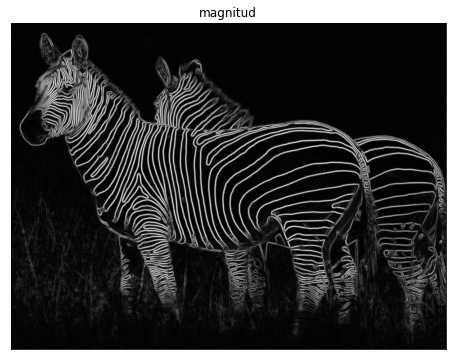

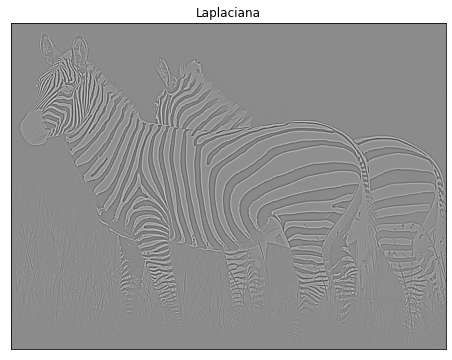

In [ ]:
def gradientIM(im, sigma, debug=True):
  return my2DConv(im, sigma, [1,0]),  my2DConv(im, sigma, [0,1])

def laplacianG(im, sigma):
  return my2DConv(im, sigma, [2,2])

sigma = 2
image = cv2.imread(get_image('zebra.jpg'), 0)

# The computation must be done in floating point !!!
im = np.array(image, np.float64)

dx, dy = gradientIM(im, sigma)
mag = np.sqrt(np.square(dx) + np.square(dy))

P0.displayIm(mag, 'magnitud')
P0.displayIm(laplacianG(im, sigma), 'Laplaciana')

En el caso de la orientación, obtenemos los valores de la función:
$$arctg(\frac{G_y}{G_x})$$
donde $G_x$ y $G_y$ son los gradientes respecto a X e Y respectivamente. Esta función devuelve un valor en $[-\pi, \pi]$.

Definimos una nueva función que nos permitirá obtener una mejor visualización. Este función asignará un color distinto dependiendo del ángulo:
*   Amarillo, si el ángulo está en $[-\pi, -\frac{\pi}{2})$.
*   Verde, si el ángulo está en $[-\frac{\pi}{2}, 0)$.
*   Azul, si el ángulo está en $[0, \frac{\pi}{2})$.
*   Rojo, si el ángulo está en $[\frac{\pi}{2}, \pi]$.

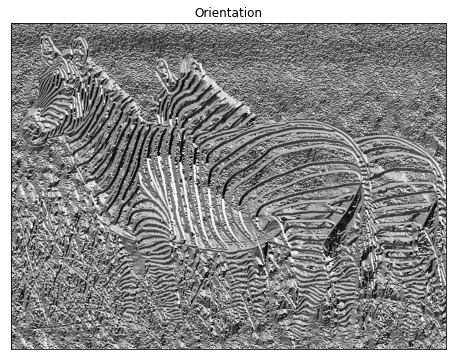

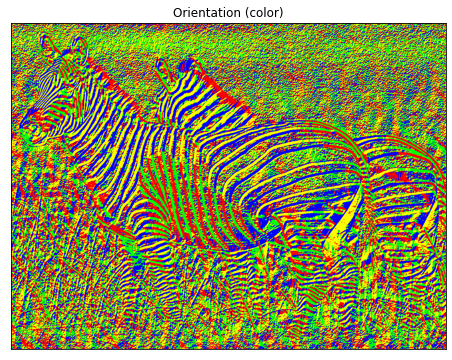

In [ ]:
def colorOrient(im):
  output = np.zeros([im.shape[0], im.shape[1], 3])
  for i in range(im.shape[0]):
    for j in range(im.shape[1]):

      if im[i, j] >= -math.pi and im[i, j] < -math.pi/2:
        output[i, j] = np.array([255.0, 255.0, 0]) # Yellow
      elif  im[i, j] >= -math.pi/2 and im[i, j] < 0:
        output[i, j] = np.array([0, 255.0, 0]) # Green
      elif im[i, j] >= 0 and im[i, j] < math.pi/2:
        output[i, j] = np.array([0, 0, 255.0]) # Blue
      elif im[i, j] >= math.pi/2 and im[i, j] <= math.pi:
        output[i, j] = np.array([255.0, 0, 0]) # Red
      else:
        output[i, j] = np.array([0.0, 0.0, 0]) # Error

  return output

sigma = 2
image = cv2.imread(get_image('zebra.jpg'), 0)
# The computation must be done in floating point !!!
im = np.array(image, np.float64)

dx, dy = gradientIM(im, sigma)
orient = np.zeros([im.shape[0], im.shape[1]])

for i in range(im.shape[0]):
  for j in range(im.shape[1]):
    orient[i, j] = math.atan2(dy[i,j], dx[i,j])

P0.displayIm(orient, 'Orientation')
P0.displayIm(colorOrient(orient), 'Orientation (color)')

Para una mejor visualización de como funciona la orientación, podemos utilizar el siguiente ejemplo:

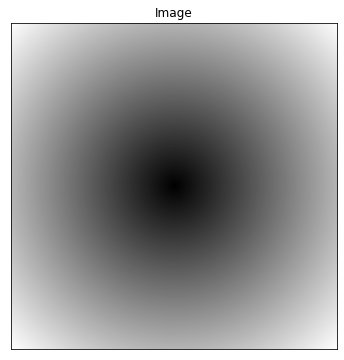

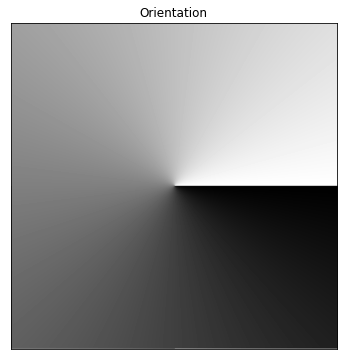

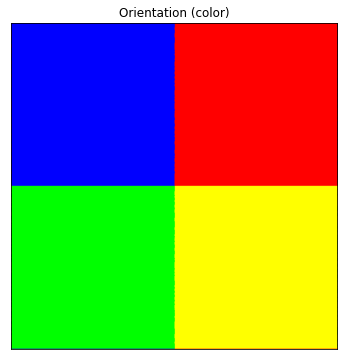

In [ ]:
im = np.zeros((1024, 1024), dtype=np.float64)
for i in range(im.shape[0]):
  for j in range(im.shape[1]):
    im[i, j] = math.sqrt(abs(i-im.shape[0]/2)**2 + abs(j-im.shape[1]/2)**2)

P0.displayIm(im, title='Image')

dx, dy = gradientIM(im, sigma)
orient = np.zeros([im.shape[0], im.shape[1]])

for i in range(im.shape[0]):
  for j in range(im.shape[1]):
    orient[i, j] = math.atan2(dy[i,j], dx[i,j])

P0.displayIm(orient, 'Orientation')
P0.displayIm(colorOrient(orient), 'Orientation (color)')

# **Exercise-2**:  Using your functions from  previous exercises, write Python functions and show results for the following tasks (6 points).





## A) 

Build up a 4-level Gaussian pyramid for an image using Gaussian masks of size 7x7.  Display all levels  in the same canvas.  (2 points)

La matriz gaussiana consiste de la imágen inicial seguida de imágenes obtenidas de reducir su tamaño y aplicándoles máscaras gaussianas.

Para reducir el tamaño, simplemente quitamos las filas y columnas pares; luego aplicamos una máscara gaussiana, y almacenamos una copia de la imagen obtenida en un vector que devolveremos. El código queda de la forma:

In [ ]:
def pyramidGauss(im, sizeMask=7, nlevel=4):
  im = np.array(im, dtype=np.float64)
  vim = []
  vim.append(im.copy())
  gaussianMask = gaussianMask1D(sigma=0, sizeMask=sizeMask, order=0).astype(dtype="float64")

  for i in range(nlevel):
    # Remove half of the columns
    im = np.delete(im, list(range(0, im.shape[1], 2)), axis=1)
    # Remove half of the rows
    im = np.delete(im, list(range(0, im.shape[0], 2)), axis=0)
    # Apply Gaussian filter
    im = cv2.sepFilter2D(src=im, ddepth=cv2.CV_64F, kernelX=gaussianMask, kernelY=gaussianMask)
    vim.append(im.copy())

  return vim

Con esto, podemos definir una función que tome este vector de las imágenes que formarán la pirámide, y definir una nueva función que las imprima por pantalla. Dicha función creará una imagen vacía (entera en negro) con el tamaño de la imagen resultante, e irá sustituyendo los pixeles con los de las imágenes de la pirámide.

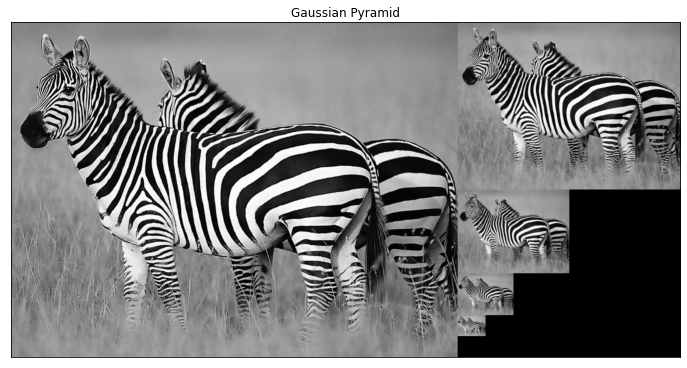

In [ ]:
def displayPyramid(vim, title=''):
  vim = vim.copy()
  # Normalize images
  for i in range(len(vim)):
    vim[i] = P0.rangeDisplay01(vim[i], 1)
    
  # Create an empty image
  if len(vim[i].shape) == 3:
    im = np.zeros((vim[0].shape[0], vim[0].shape[1] + vim[1].shape[1], 3))
  elif len(vim[i].shape) == 2:
    im = np.zeros((vim[0].shape[0], vim[0].shape[1] + vim[1].shape[1], 3))
  else:
    print("ERROR: Invalid image dimensions.")
    return 0

  # Add first image (biggest)
  for i in range(vim[0].shape[0]):
    for j in range(vim[0].shape[1]):
      im[i,j] = vim[0][i,j]

  # Add other images
  posX = 0
  posY = vim[0].shape[1]
  for n in range(1, len(vim)):
    for i in range(vim[n].shape[0]):
      for j in range(vim[n].shape[1]):
        im[i + posX, j + posY] = vim[n][i,j]
    posX += vim[n].shape[0]

  return P0.displayIm(im, title=title, factor=1.5)

im = cv2.imread(get_image('zebra.jpg'), 0)
pyrG = pyramidGauss(im, sizeMask=7, nlevel=4)
displayPyramid(pyrG,'Gaussian Pyramid')

## B)

Using your code from A), implement a function to build a 4-level Laplacian pyramid.  The type of interpolation employed is now relevant. Show two examples using the images provided. Show all levels on the same canvas. (2 points) 

La pirámide laplaciana es la resultante de, a partir de la matriz gaussiana, a cada imágen le restamos la siguiente (de mitad de tamaño) reescalada para que tenga las mismas dimensiones, y guardamos esta diferencia.

Tras realizar este procedimiento con todas las imágenes, simplemente añadimos la última imagen, la de menor tamaño, a partir de la cuál podremos recustruir la imagen original reescalando y sumando todas las diferencias que hemos almacenado.

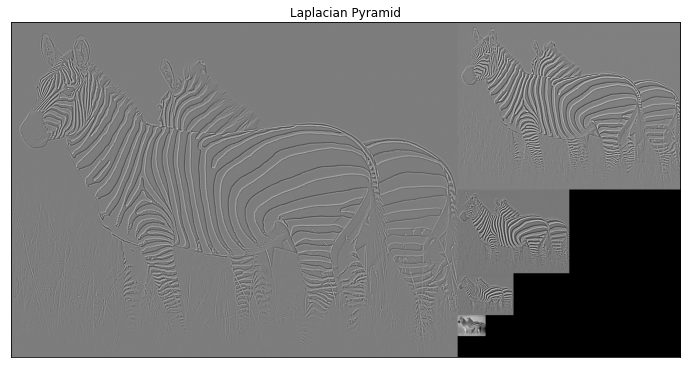

In [ ]:
def pyramidLap(im, sizeMask, nlevel=4, flagInterp=cv2.INTER_LINEAR):
  im = np.array(im, dtype=np.float64)
  # Gaussian pyramid
  vim = pyramidGauss(im, sizeMask, nlevel)
  vimL = []

  for i in range(1, len(vim)):
    # Calculate difference between an image and itself smoothed
    resize = cv2.resize(vim[i], dsize=(vim[i-1].shape[1], vim[i-1].shape[0]), interpolation=flagInterp)
    im = vim[i-1] - resize
    vimL.append(im)

  vimL.append(vim[len(vim)-1])
  return vimL

im = cv2.imread(get_image('zebra.jpg'), 0)
pyrL = pyramidLap(im,sizeMask=7, nlevel=4)
displayPyramid(pyrL,'Laplacian Pyramid')

## C) 

Implement a function to reconstruct the image encoded in the Laplacian pyramid. Take one of the pyramids from B) and verify that it is possible to obtain an exact copy of the original image. To do this, calculate the Frobenius norm of the difference between the original and the reconstructed images.(2 points)

Finalmente, vamos a intentar reconstuir la imagen inicial a partir de la matriz laplaciana.

Para ello, comenzamos con la última imagen de la matriz laplaciana, la de menor tamaño, que obtenemos tras repetir el procedimiento de eliminar las filas y columnas de la imagen y suavizar aplicando la máscara gaussiana varias veces.

A partir de esta imagen, la reescalamos para que tenga el mismo tamaño que la siguiente imagen, y le sumamos la matriz de la pirámide laplaciana correspondiente, que contiene las diferencias con respecto a la imágen de la matriz gaussiana correspondiente,

In [ ]:
def reconstructIm(pyL, flagInterp=cv2.INTER_LINEAR):
  # Start with the smoothed image
  im = pyL[len(pyL)-1]
  for i in range(len(pyL)-2, -1, -1):
    # Resize to the next image
    im = cv2.resize(im, pyL[i].T.shape, interpolation=flagInterp)
    # Add the difference
    im += pyL[i]
  return im

im = cv2.imread(get_image('zebra.jpg'), 0).astype(np.float64)
pyrL = pyramidLap(im, sizeMask=7, nlevel=4)
recons = reconstructIm(pyrL, cv2.INTER_LINEAR)
print('Error per pixel', np.sqrt(np.linalg.norm(im-np.round(recons),ord=2)/np.prod(im.shape)))
# The final error must be 0.0

Error per pixel 0.0


Para una mayor visualización, vamos a definir una nueva función en la que almacenamos todas los pasos de la reconstrucción de la imagen, para poder representarlas:

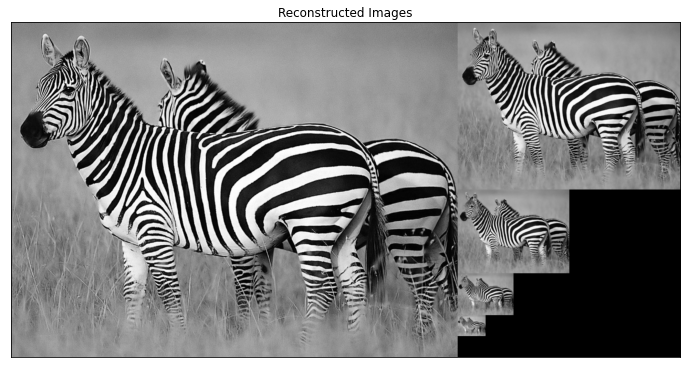

In [ ]:
def displayReconstructIm(pyL, flagInterp=cv2.INTER_LINEAR):
  # Start with the smoothed image
  im = pyL[len(pyL)-1]
  vim = []
  vim.append(im.copy())
  for i in range(len(pyL)-2, -1, -1):
    # Resize to the next image
    im = cv2.resize(im, pyL[i].T.shape, interpolation=flagInterp)
    # Add the difference
    im += pyL[i]
    vim.append(im.copy())
  return displayPyramid(vim[::-1], 'Reconstructed Images')

im = cv2.imread(get_image('zebra.jpg'), 0).astype(np.float64)
pyrL = pyramidLap(im, sizeMask=7, nlevel=4)
displayReconstructIm(pyrL, cv2.INTER_LINEAR)

Como podemos ver, en todas las imágenes obtenemos la imagen inicial y las reducciones de tamaño obtenidas de eliminas las filas y columnas pares.

También podemos ver otro caso interesante: el valor de $\sigma$ no importa para la reconstrucción, es decir, podemos aplicar un valor mayor de $\sigma$ y obtener así una imagen irreconocible, y aún así obtener la imagen inicial, como podemos ver en el siguiente ejemplo:

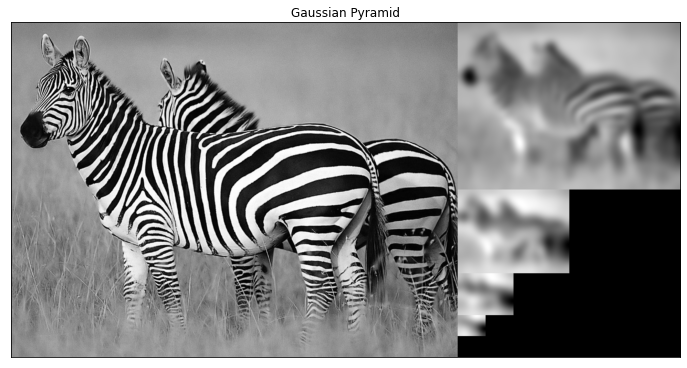

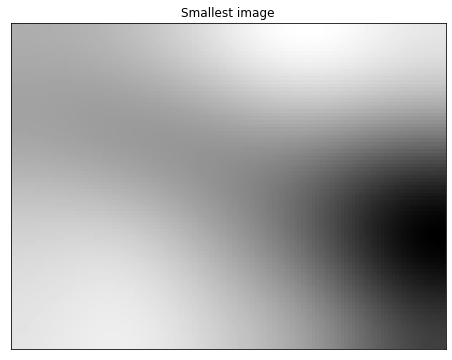

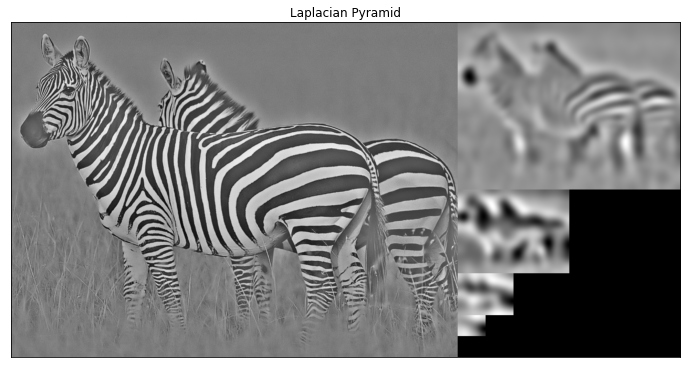

Error per pixel 0.0


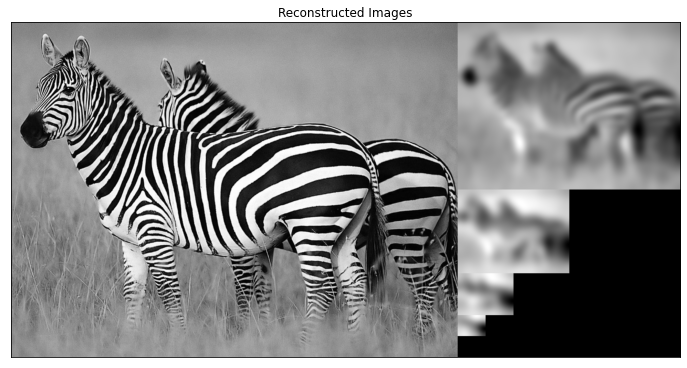

In [ ]:
im = cv2.imread(get_image('zebra.jpg'), 0)

pyrG = pyramidGauss(im, sizeMask=101, nlevel=4)
displayPyramid(pyrG,'Gaussian Pyramid')

P0.displayIm(pyrG[len(pyrG)-1], title="Smallest image")

pyrL = pyramidLap(im,sizeMask=101, nlevel=4)
displayPyramid(pyrL,'Laplacian Pyramid')

recons = reconstructIm(pyrL, cv2.INTER_LINEAR)
print('Error per pixel', np.sqrt(np.linalg.norm(im-np.round(recons),ord=2)/np.prod(im.shape)))

displayReconstructIm(pyrL, cv2.INTER_LINEAR)

# **BONUS: HYBRID IMAGES** (3 points)

This bonus section is based on the following paper about hybrid imaging: SIGGRAPH 2006 paper by Oliva, Torralba, and Schyns (https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf).  

 The goal of this bonus is to learn how the human visual system extracts information about an object depending on the distance. To do this, we construct a hybrid image from two images of different objects. By appropriately mixing part of the high frequencies of one image with part of the low frequencies of another image, we obtain a hybrid image that shows different perceptions with distance.  The smoothing of both images is the key aspect to select the high and low frequency range of each image.  The higher the sigma value, the greater the removal of high frequencies from the image. It is recommendable to choose this value separately for each of the images (see recommendations given in the article by Oliva et al.) and, in fact, more than one value may be possible. Steps to follow: 
 
1. Read the paper. 

2. Find the appropriate sigma values for each pair of images. Extract the low and high frequency images and calculate the hybrid image as the average of them. (Hint: the low frequencies must be really low).

3. Test at least two pairs of the provided ones. (Hint: Try gray level images first).

4. Use your visualization functions to display the Gaussian pyramid of the hybrid images. Explain the visual effect perceived. 

Para este ejercicio queremos obtener una imagen de baja frecuencia obtenida de aplicar una máscara gaussiana, y una imagen de alta frecuencia, que podemos obtener de diversos modos como de la matriz laplaciana definida en el ejericicio anterior o, como utilizaré, restandole a la imagen ella misma pero suavizada tras aplicarle una máscara gaussiana.

Sumando estas dos imágenes obtendremos una nueva imagen que sera una combinación de ambas, en la cual veremos la imagen de alta frecuencia si vemos la imagen desde cerca o la imagen de baja frecuencia si vemos la imagen desde lejos.

Los resultados obtenidos pueden variar dependiendo de los valores de $\sigma$ que utilicemos para calcular dichas imagenes, teniendo que hacer varias pruebas con distintos valores hasta obtener una imagen con el efecto deseado.

La función que usaremos es la siguiente:

In [ ]:
def bonus(vim, sigma_low, sigma_high):
  low = my2DConv(im=vim[0], sigma=sigma_low, orders=[0,0])
  # Option 1:
  # high = pyramidLap(im=vim[1], sizeMask=7, nlevel=4)[0]
  # Option 2:
  high = vim[1] - my2DConv(vim[1], sigma_high, [0,0])
  im = low + high
  pyrG = pyramidGauss(im=im, sizeMask=7, nlevel=4)
  return displayPyramid(pyrG, title="Bonus")

Veamos las imágenes tando la de alta frecuencia como la de baja frecuencia, y el resultado de la suma de ambas:

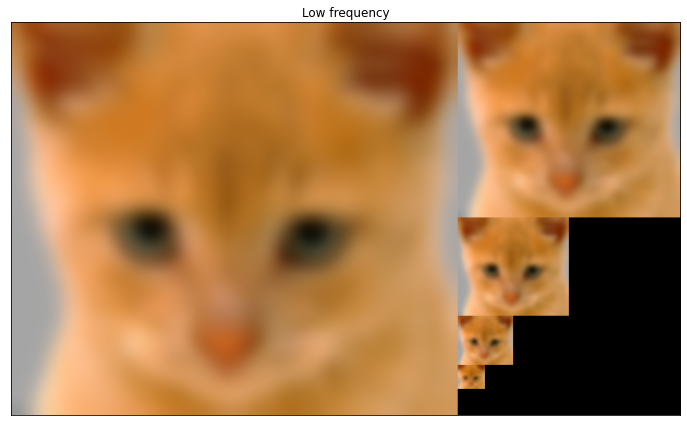

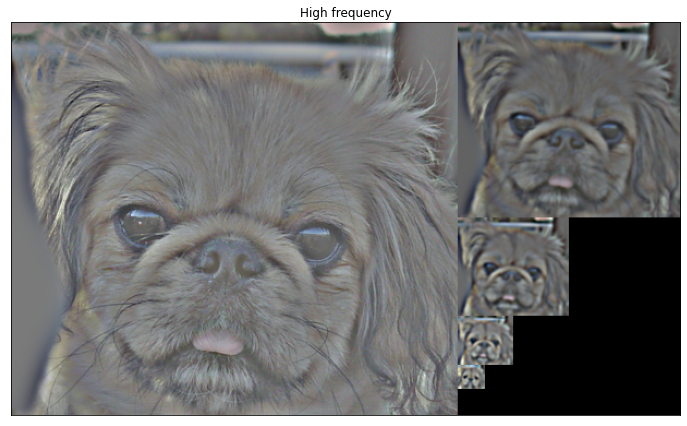

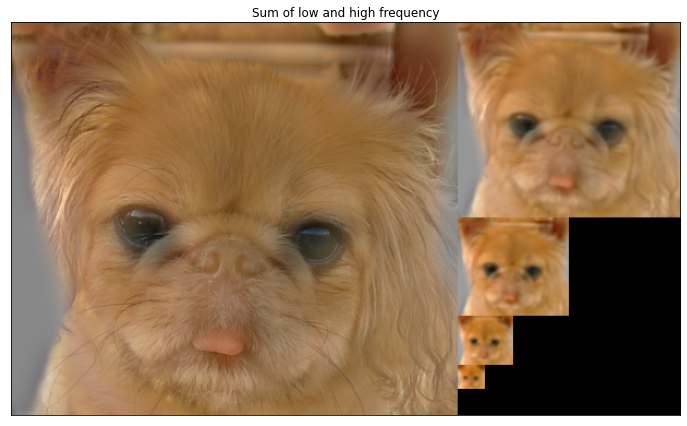

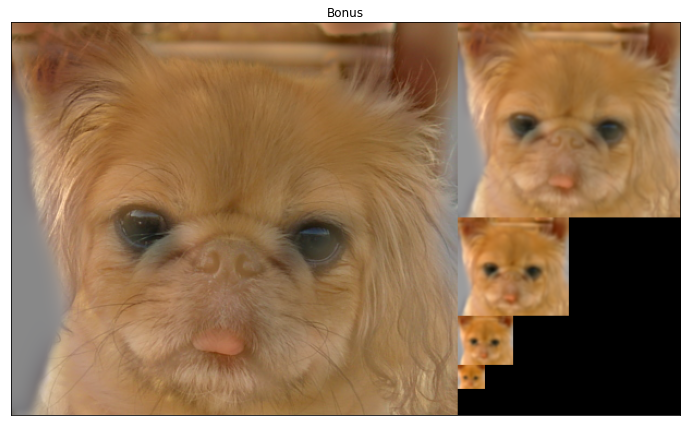

In [ ]:
vim = []
vim.append(cv2.cvtColor(cv2.imread(get_image('cat.bmp'), 1), cv2.COLOR_RGB2BGR))
vim.append(cv2.cvtColor(cv2.imread(get_image('dog.bmp'), 1), cv2.COLOR_RGB2BGR))

pyrL = pyramidGauss(my2DConv(im=vim[0], sigma=8, orders=[0,0]), sizeMask=7, nlevel=4)
displayPyramid(pyrL, 'Low frequency')

pyrH = pyramidGauss(vim[1] - my2DConv(vim[1], sigma=10, orders=[0,0]), sizeMask=7, nlevel=4)
displayPyramid(pyrH, title="High frequency")

# Sum of both pyramid
pyrB = []
for i in range(len(pyrL)):
  pyrB.append(pyrL[i] + pyrH[i])
displayPyramid(pyrB, title="Sum of low and high frequency")

bonus(vim, 8, 10)

Veamos los resultados obtenidos con varios pares de imágenes con color:

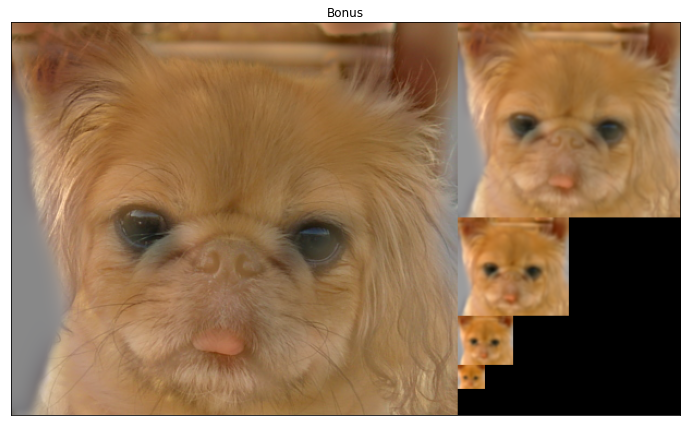

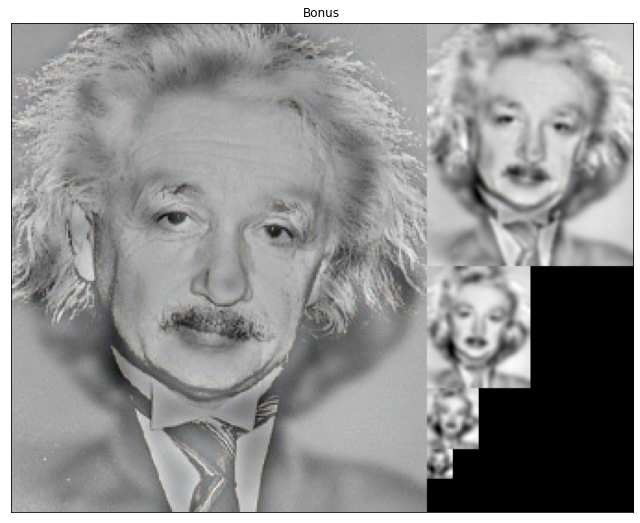

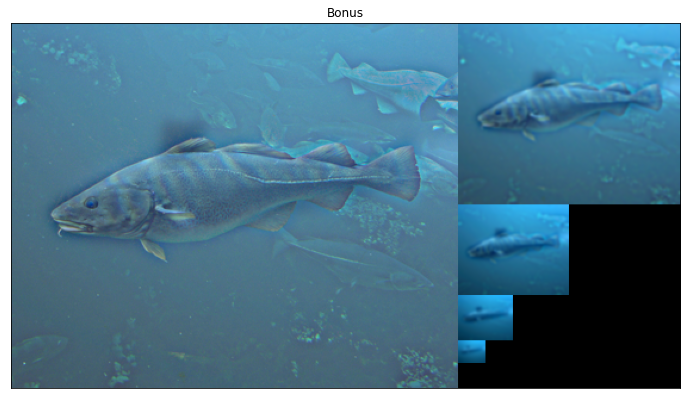

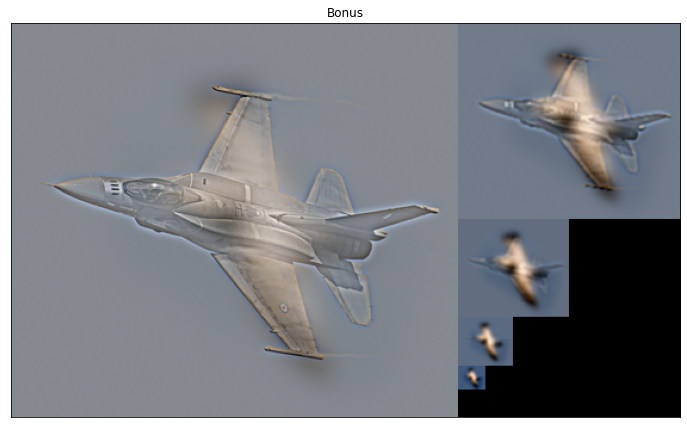

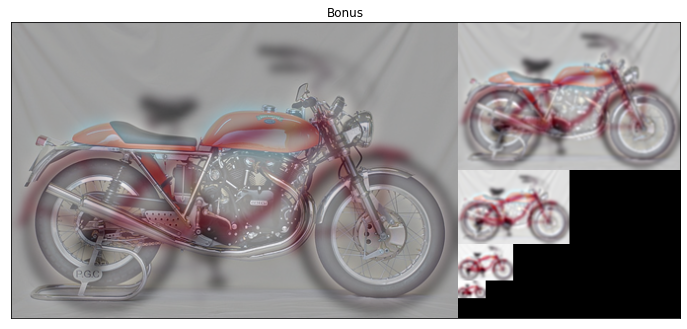

In [ ]:
vim = []
vim.append(cv2.cvtColor(cv2.imread(get_image('cat.bmp'), 1), cv2.COLOR_RGB2BGR))
vim.append(cv2.cvtColor(cv2.imread(get_image('dog.bmp'), 1), cv2.COLOR_RGB2BGR))
bonus(vim, 8, 10)

vim = []
vim.append(cv2.cvtColor(cv2.imread(get_image('marilyn.bmp'), 1), cv2.COLOR_RGB2BGR))
vim.append(cv2.cvtColor(cv2.imread(get_image('einstein.bmp'), 1), cv2.COLOR_RGB2BGR))
bonus(vim, 3, 5)

vim = []
vim.append(cv2.cvtColor(cv2.imread(get_image('submarine.bmp'), 1), cv2.COLOR_RGB2BGR))
vim.append(cv2.cvtColor(cv2.imread(get_image('fish.bmp'), 1), cv2.COLOR_RGB2BGR))
bonus(vim, 5, 5)

vim = []
vim.append(cv2.cvtColor(cv2.imread(get_image('bird.bmp'), 1), cv2.COLOR_RGB2BGR))
vim.append(cv2.cvtColor(cv2.imread(get_image('plane.bmp'), 1), cv2.COLOR_RGB2BGR))
bonus(vim, 10, 3)

vim = []
vim.append(cv2.cvtColor(cv2.imread(get_image('bicycle.bmp'), 1), cv2.COLOR_RGB2BGR))
vim.append(cv2.cvtColor(cv2.imread(get_image('motorcycle.bmp'), 1), cv2.COLOR_RGB2BGR))
bonus(vim, 5, 8)

También podemos obtener el mismo efecto con imágenes en blanco y negro, aunque habrá que modificar algunos valores de $\sigma$:

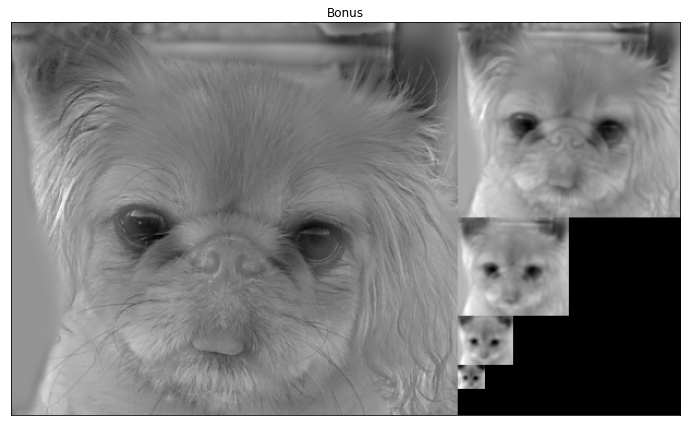

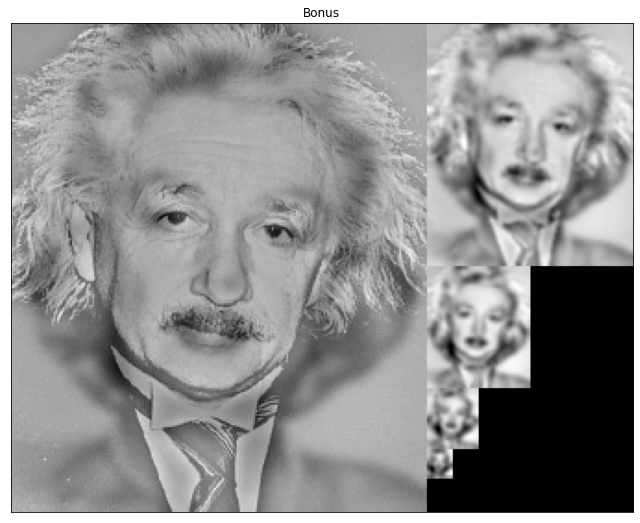

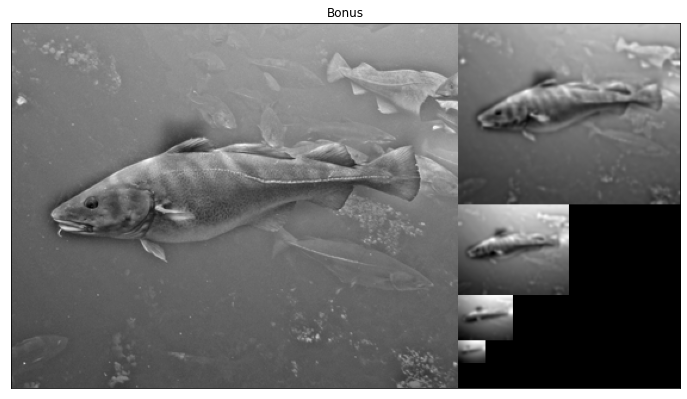

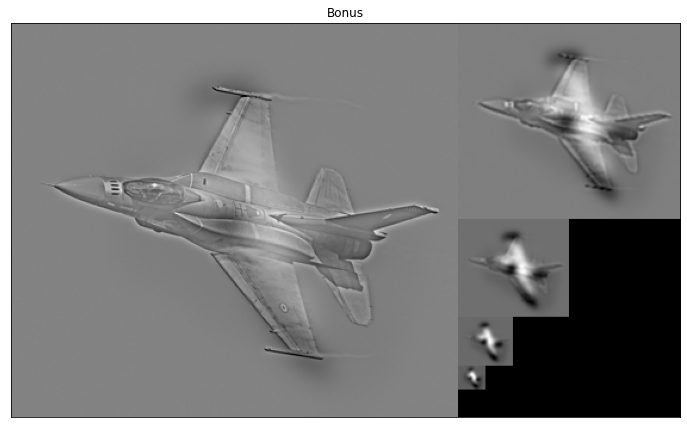

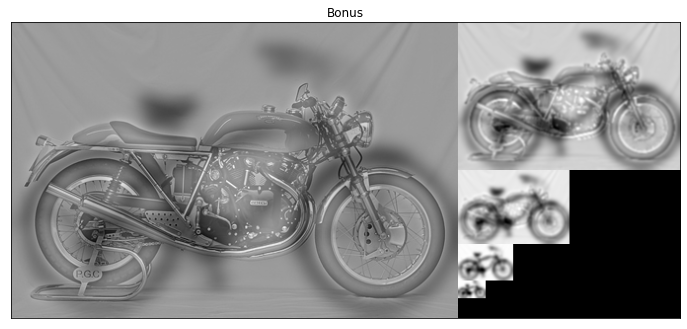

In [ ]:
vim = []
vim.append(cv2.imread(get_image('cat.bmp'), 0))
vim.append(cv2.imread(get_image('dog.bmp'), 0))
bonus(vim, 8, 6)

vim = []
vim.append(cv2.imread(get_image('marilyn.bmp'), 0))
vim.append(cv2.imread(get_image('einstein.bmp'), 0))
bonus(vim, 3, 5)

vim = []
vim.append(cv2.imread(get_image('submarine.bmp'), 0))
vim.append(cv2.imread(get_image('fish.bmp'), 0))
bonus(vim, 5, 6)

vim = []
vim.append(cv2.imread(get_image('bird.bmp'), 0))
vim.append(cv2.imread(get_image('plane.bmp'), 0))
bonus(vim, 10, 3)

vim = []
vim.append(cv2.imread(get_image('bicycle.bmp'), 0))
vim.append(cv2.imread(get_image('motorcycle.bmp'), 0))
bonus(vim, 8, 5)